<a href="https://colab.research.google.com/github/edmgjr/portifolio/blob/main/Avalia%C3%A7%C3%A3o_1_Aprendizado_de_M%C3%A1quina_e_Reconhecimento_de_Padr%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

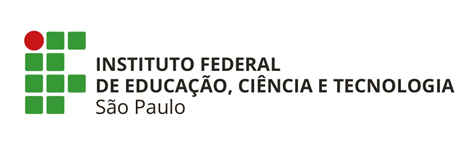

<h1><center>Avaliação 1</center></h1>
<br>

<h3><center>APRENDIZADO DE MÁQUINA DE RECONHECIMENTO DE PADRÕES (D2APR)</center></h3>
<br>

<h3><center>Pós Graduação – Ciência de Dados
<br>
Professor:  Samuel Martins</center></h3>

<br>
<br>

<h4><right>Ede Miranda Júnior – CP3013596
<br>
Vitor Felipe Facanali Godoy – CP3013669</right></h4>
<br>
<br>

<h3><center>Campinas, São Paulo</center></h3>



#Inicialização das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import os.path
import io
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, mean_squared_log_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor 

#1. Carregamento do dataset

In [ ]:
path = files.upload()

Saving sao-paulo-properties-april-2019.csv to sao-paulo-properties-april-2019 (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(path['sao-paulo-properties-april-2019.csv']))
print(df.head())
print(df.info())

   Price  Condo  Size  ...  Property Type   Latitude  Longitude
0    930    220    47  ...      apartment -23.543138 -46.479486
1   1000    148    45  ...      apartment -23.550239 -46.480718
2   1000    100    48  ...      apartment -23.542818 -46.485665
3   1000    200    48  ...      apartment -23.547171 -46.483014
4   1300    410    55  ...      apartment -23.525025 -46.482436

[5 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished

#2. Introdução

O conjunto de dados *Imóveis em São Paulo - Venda / Aluguel - abril de 2019*, disponível no site [Kaggle](https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019), contém informações de 13640 imóveis capturadas de diferentes plataformas de anúncios de aluguel e/ou venda de imóveis da cidade de São Paulo ofertadas no mês de abril de 2019.


O banco de dados em sí, que consta de apenas 1 tabela, com seus dados separados por vígula, possui os seguintes argumentos:
<br>
<br>
- inteiros:

  - Price, que mostra o preço do anúncio
  - Condo, trazendo o preço do condomínio atrelado ao imóvel, sendo 0 caso não possua
  - Size, significando o tamanho do imóvel
  - Rooms, quantidade de quartos
  - Toilets, quantidade de banheiros
  - Suites, quantidade de quartos com banheiro privativo 
  - Parking, quantidade de vagas disponíveis 
<br>
<br>
- binários:
  - Elevator, bit para determinar se há (1) ou não (0) elevador no imóvel
  - Furnished, bit para determinar se o imóvel está (1) ou não (0) mobiliado 
  - Swimming Pool, bit que informa se há (1) ou não (0) piscina
  - New, bit que indica se o imóvel é novo (1) ou não (0) 
<br>
<br>
- texto:
  - District, informa qual bairro está situado o imóvel
  - Negotiation Type, informa se o anúncio se trata de uma venda ou de um aluguel 
  - Property Type, informa o tipo de imóvel, porém o data set apresenta apenas dados de apartamentos
<br>
<br>
- float:
  - Latitude
  - Longitude

O principal objetivo desse trabalho é conseguir construir um modelo, utilizando técnicas de aprendizado de máquina, que consiga determinar o preço de um imóvel a partir das características do mesmo.

#3. Limpeza e Pré-processamento de Dados

In [ ]:
housing_pre  = df.copy()
housing_pre.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


In [ ]:
#checando se há valores duplicados
housing_pre.duplicated().any()

True

In [ ]:
#removendo valores duplicados
housing_pre.drop_duplicates(inplace=True)

In [ ]:
#alterando o nome das colunas que possuem espaço
housing_pre.columns = housing_pre.columns.str.replace(' ', '_')

In [ ]:
#Convertendo valores de int pra float
for attribute in ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']:
  housing_pre[attribute] = housing_pre[attribute].astype(float)

In [ ]:
housing_pre

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
0,930.0,220.0,47.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000.0,148.0,45.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000.0,100.0,48.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000.0,200.0,48.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300.0,410.0,55.0,2.0,2.0,1.0,1.0,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000.0,420.0,51.0,2.0,1.0,0.0,1.0,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000.0,630.0,74.0,3.0,2.0,1.0,2.0,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000.0,1100.0,114.0,3.0,3.0,1.0,1.0,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000.0,48.0,39.0,1.0,2.0,1.0,1.0,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


##2.1. Price

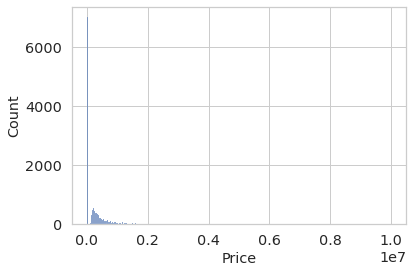

In [ ]:
sns.histplot(data=housing_pre, x='Price')

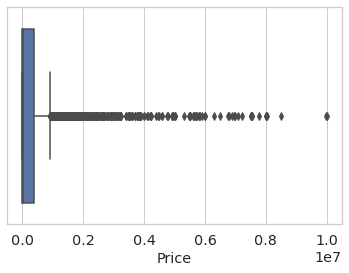

In [ ]:
#checando a existencia de outliers
sns.boxplot(data=housing_pre, x='Price')

In [ ]:
housing_pre['Price'].sort_values(ascending=False)

6282    10000000.0
6287     9979947.0
7249     8500000.0
5008     8039200.0
5006     8000000.0
           ...    
4486         500.0
288          500.0
122          500.0
2878         500.0
508          480.0
Name: Price, Length: 13321, dtype: float64

In [ ]:
housing_pre.query('Price >= 1e6').sort_values(by='Price', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
6282,10000000.0,0.0,343.0,4.0,7.0,4.0,5.0,0,0,0,0,Iguatemi/São Paulo,sale,apartment,-23.585487,-46.681676
6287,9979947.0,0.0,343.0,4.0,6.0,4.0,5.0,1,0,1,0,Iguatemi/São Paulo,sale,apartment,-23.585487,-46.681676
7249,8500000.0,7200.0,420.0,4.0,6.0,4.0,4.0,1,0,1,0,Jardim Paulista/São Paulo,sale,apartment,-23.564044,-46.660862
5008,8039200.0,0.0,278.0,4.0,7.0,4.0,4.0,1,1,1,0,Vila Olimpia/São Paulo,sale,apartment,-23.596469,-46.680587
7152,8000000.0,0.0,269.0,4.0,5.0,4.0,4.0,1,0,1,0,Itaim Bibi/São Paulo,sale,apartment,-23.588294,-46.680764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,1000000.0,3000.0,170.0,3.0,4.0,3.0,3.0,0,0,1,0,Perdizes/São Paulo,sale,apartment,0.000000,0.000000
9015,1000000.0,1368.0,125.0,3.0,2.0,1.0,1.0,0,0,0,0,Perdizes/São Paulo,sale,apartment,-23.534891,-46.668823
7880,1000000.0,1400.0,140.0,3.0,4.0,1.0,2.0,1,0,1,0,Perdizes/São Paulo,sale,apartment,-23.532720,-46.674910
11228,1000000.0,1200.0,103.0,2.0,3.0,1.0,2.0,1,1,0,0,Bela Vista/São Paulo,sale,apartment,-23.563782,-46.643343


Aparentemente os outliers estão diretamente ligado ao atributo 'Negotiation_Type', os valores mais altos são de imóveis que estão a venda, e os valores mais baixos estão ligados a valores de aluguel do imóvel.

Os outliers não serão removidos pois esses valores são verdadeiros.

Na etapa de Análise Exploratória esse atributo será análisado nos casos de aluguel e venda separadamente.

##2.2. Condo

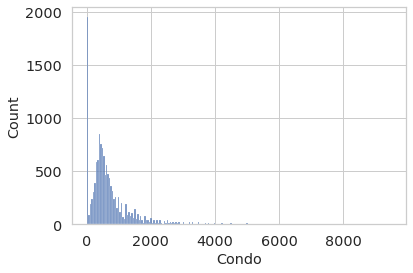

In [ ]:
sns.histplot(data=housing_pre, x='Condo')

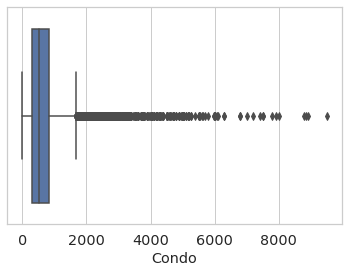

In [ ]:
#checando a existencia de outliers
sns.boxplot(data=housing_pre, x='Condo')

In [ ]:
housing_pre.query('Condo >= 2000').sort_values(by='Condo', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
4228,10000.0,9500.0,452.0,4.0,3.0,2.0,4.0,1,0,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.550756,-46.719548
8959,7200000.0,8920.0,387.0,4.0,5.0,4.0,4.0,0,0,0,0,Alto de Pinheiros/São Paulo,sale,apartment,-23.557159,-46.692755
10684,8000.0,8860.0,414.0,4.0,5.0,4.0,4.0,0,0,1,0,Moema/São Paulo,rent,apartment,-23.599840,-46.664337
10669,30000.0,8800.0,640.0,4.0,5.0,4.0,5.0,0,1,1,0,Moema/São Paulo,rent,apartment,-23.599839,-46.664336
4269,15000.0,8000.0,452.0,4.0,5.0,4.0,6.0,0,0,0,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.550756,-46.719548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11178,3000.0,2000.0,160.0,4.0,2.0,1.0,3.0,0,0,0,0,Mooca/São Paulo,rent,apartment,-23.572107,-46.590849
11183,4500.0,2000.0,223.0,4.0,1.0,4.0,1.0,0,0,1,0,Mooca/São Paulo,rent,apartment,-23.557157,-46.590724
3899,3500.0,2000.0,210.0,4.0,3.0,2.0,3.0,0,0,1,0,Morumbi/São Paulo,rent,apartment,-23.611760,-46.732601
3615,5500.0,2000.0,36.0,1.0,2.0,1.0,1.0,0,1,1,0,Itaim Bibi/São Paulo,rent,apartment,-23.594305,-46.681101


O Atributo 'Condo' também apresenta outliers, aparentemente ele esta relacionado ao tamanho do imovel e o numero de vagas de estacionamentos.

Esses outliers não serão removidos pois refletem valores que realmente existem.

In [ ]:
housing_pre.query('Condo < 1').sort_values(by='Condo', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
5,1170.0,0.0,50.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.548751,-46.477195
9016,700000.0,0.0,80.0,3.0,2.0,1.0,1.0,1,0,0,0,Perdizes/São Paulo,sale,apartment,-23.540860,-46.679945
9164,3500.0,0.0,41.0,1.0,2.0,1.0,1.0,0,0,0,0,Consolação/São Paulo,rent,apartment,-23.553068,-46.654288
9159,2500.0,0.0,80.0,2.0,2.0,1.0,1.0,1,0,0,0,Brás/São Paulo,rent,apartment,-23.539452,-46.614453
9113,3300.0,0.0,130.0,3.0,2.0,1.0,1.0,1,0,0,0,Bom Retiro/São Paulo,rent,apartment,-23.528376,-46.634561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5914,362677.0,0.0,59.0,3.0,2.0,1.0,1.0,1,0,1,0,Vila Maria/São Paulo,sale,apartment,-23.516304,-46.590937
5910,362700.0,0.0,59.0,3.0,3.0,1.0,2.0,1,0,1,1,Vila Maria/São Paulo,sale,apartment,-23.515731,-46.586219
5902,315000.0,0.0,50.0,2.0,2.0,1.0,1.0,1,1,1,0,Vila Guilherme/São Paulo,sale,apartment,-23.499470,-46.594511
5901,285000.0,0.0,50.0,2.0,2.0,1.0,1.0,1,1,1,0,Vila Guilherme/São Paulo,sale,apartment,-23.518819,-46.603798


Existe uma grande quantidade de instâncias com valores zerados para o atributo 'Condo'. Provavelmente esses valores são de apartamentos que não possuem serviços de condomínio, ou o valor de condomínio pode estar incluído no valor de aluguel

##2.3. Size

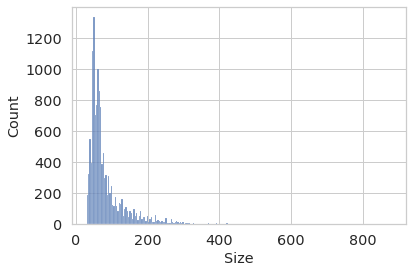

In [ ]:
sns.histplot(data=housing_pre, x='Size')

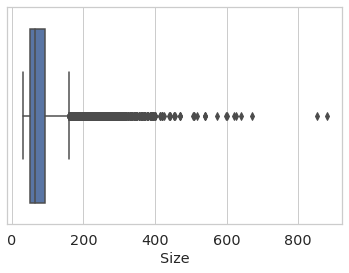

In [ ]:
#checando a existencia de outliers
sns.boxplot(data=housing_pre, x='Size')

In [ ]:
housing_pre.query('Size >= 200').sort_values(by='Size', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
3865,19900.0,7800.0,880.0,5.0,4.0,5.0,6.0,1,0,0,0,Morumbi/São Paulo,rent,apartment,-23.623140,-46.719525
10698,8700.0,5040.0,852.0,7.0,6.0,5.0,6.0,1,0,1,0,Morumbi/São Paulo,rent,apartment,-26.922512,-49.060707
3408,50000.0,5500.0,670.0,5.0,6.0,5.0,7.0,0,0,1,0,Campo Belo/São Paulo,rent,apartment,-23.625617,-46.674614
10669,30000.0,8800.0,640.0,4.0,5.0,4.0,5.0,0,1,1,0,Moema/São Paulo,rent,apartment,-23.599839,-46.664336
3800,25000.0,7500.0,627.0,4.0,5.0,4.0,6.0,0,0,1,0,Moema/São Paulo,rent,apartment,-23.605854,-46.655442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,2500.0,2200.0,200.0,4.0,2.0,1.0,2.0,0,0,0,0,Bom Retiro/São Paulo,rent,apartment,0.000000,0.000000
2260,2500.0,1837.0,200.0,3.0,2.0,1.0,1.0,0,0,0,0,Bom Retiro/São Paulo,rent,apartment,-23.528518,-46.632135
2255,2500.0,2200.0,200.0,4.0,2.0,1.0,2.0,1,0,0,0,Bom Retiro/São Paulo,rent,apartment,-23.528219,-46.633877
2221,4900.0,2415.0,200.0,3.0,2.0,1.0,1.0,0,0,1,0,Bela Vista/São Paulo,rent,apartment,-23.563999,-46.653642


Também há outlier para o atributo 'Size', que também refletem valores de tamanhos de móveis que podem existir, e por isso não serão removidos.

##2.4. Rooms

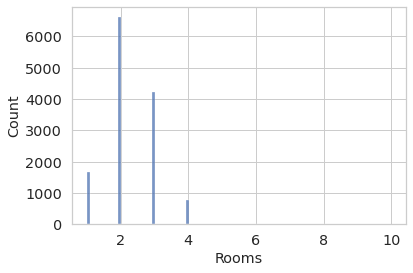

In [ ]:
sns.histplot(data=housing_pre, x='Rooms')

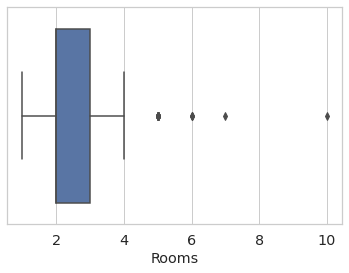

In [ ]:
#checando a existencia de outliers
sns.boxplot(data=housing_pre, x='Rooms')

In [ ]:
housing_pre.query('Rooms > 4').sort_values(by='Rooms', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
1340,8000.0,0.0,273.0,10.0,4.0,1.0,8.0,0,0,0,0,Santo Amaro/São Paulo,rent,apartment,-23.626021,-46.682821
10698,8700.0,5040.0,852.0,7.0,6.0,5.0,6.0,1,0,1,0,Morumbi/São Paulo,rent,apartment,-26.922512,-49.060707
9941,14000.0,5800.0,400.0,6.0,8.0,2.0,2.0,1,1,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.560194,-46.656695
3864,8000.0,4200.0,510.0,6.0,5.0,4.0,3.0,0,0,1,0,Morumbi/São Paulo,rent,apartment,-23.610492,-46.731456
8949,7521000.0,2500.0,377.0,6.0,7.0,6.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,sale,apartment,-23.549506,-46.717449
989,4000.0,800.0,200.0,5.0,1.0,4.0,2.0,0,0,1,0,Cidade Dutra/São Paulo,rent,apartment,-23.714197,-46.702117
7305,1590000.0,1800.0,170.0,5.0,5.0,2.0,2.0,0,1,1,0,Moema/São Paulo,sale,apartment,-23.608920,-46.663353
11865,4100000.0,3900.0,295.0,5.0,6.0,4.0,4.0,0,0,1,0,Perdizes/São Paulo,sale,apartment,-23.539891,-46.672997
10471,6700.0,2600.0,330.0,5.0,4.0,3.0,2.0,0,1,0,0,Tatuapé/São Paulo,rent,apartment,-23.553040,-46.572567
10222,6500.0,1550.0,234.0,5.0,5.0,4.0,3.0,0,0,0,0,Rio Pequeno/São Paulo,rent,apartment,-23.555380,-46.737744


O atributo 'Rooms' possui outliers com número de quartos. Uma instância em específico possui 10 quartos, porém seu metro quadrado não suporta essa quantidade de quartos, portanto essa instância será removida.

In [ ]:
housing_pre = housing_pre.query('Rooms < 10').reset_index(drop=True)

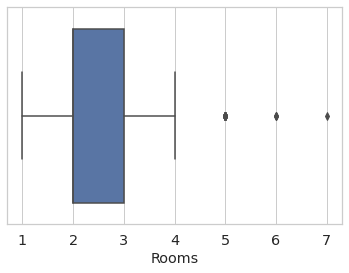

In [ ]:
sns.boxplot(data=housing_pre, x='Rooms')

Ainda existem outliers para esse atributo, porém esses valores são mais próximos do real

##2.5. Toilets

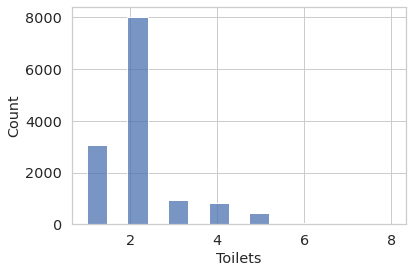

In [ ]:
sns.histplot(data=housing_pre, x='Toilets')

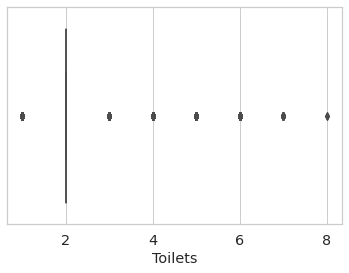

In [ ]:
sns.boxplot(data=housing_pre, x='Toilets')

Aparentemente a concentração da média de número de banheiros esta concentrada em 2 banheiros por imóvel

In [ ]:
housing_pre.query('Toilets > 2').sort_values(by='Toilets', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
9285,6000.0,0.0,313.0,5.0,8.0,4.0,4.0,1,0,1,0,Medeiros/São Paulo,rent,apartment,-23.599178,-46.728962
9698,14000.0,5800.0,400.0,6.0,8.0,2.0,2.0,1,1,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.560194,-46.656695
8731,7521000.0,2500.0,377.0,6.0,7.0,6.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,sale,apartment,-23.549506,-46.717449
1159,26000.0,4400.0,300.0,4.0,7.0,4.0,5.0,1,1,1,0,Moema/São Paulo,rent,apartment,-23.610405,-46.659519
4854,8039200.0,0.0,278.0,4.0,7.0,4.0,4.0,1,1,1,0,Vila Olimpia/São Paulo,sale,apartment,-23.596469,-46.680587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,698500.0,1000.0,103.0,3.0,3.0,1.0,2.0,0,0,0,0,Carrão/São Paulo,sale,apartment,0.000000,0.000000
5992,678900.0,1000.0,119.0,3.0,3.0,1.0,2.0,1,0,1,0,Carrão/São Paulo,sale,apartment,-23.550535,-46.530384
5984,830000.0,0.0,98.0,3.0,3.0,1.0,2.0,1,0,1,0,Carrão/São Paulo,sale,apartment,-23.552012,-46.537754
5980,685900.0,580.0,96.0,3.0,3.0,1.0,2.0,1,0,1,1,Carrão/São Paulo,sale,apartment,-23.540323,-46.551478


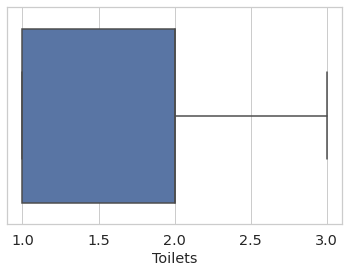

In [ ]:
sns.boxplot(data=housing_pre.query('Toilets <= 3'), x='Toilets')

De fato, mesmo possuindo outliers o numero de de banheiros maior que 2 podem existir, por isso não serão removidos.

##2.6. Suites

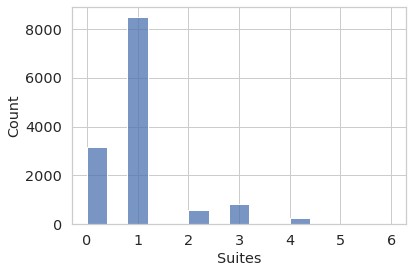

In [ ]:
sns.histplot(data=housing_pre, x='Suites')

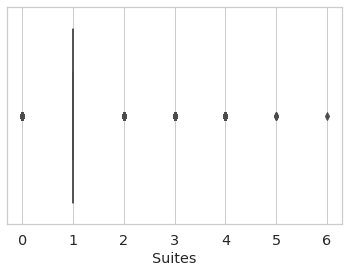

In [ ]:
sns.boxplot(data=housing_pre, x='Suites')

O atributo 'Suites' tem sua média concentrada em 1 suite por imóvel

In [ ]:
housing_pre.query('Suites > 2').sort_values(by='Suites', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
8731,7521000.0,2500.0,377.0,6.0,7.0,6.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,sale,apartment,-23.549506,-46.717449
10434,8700.0,5040.0,852.0,7.0,6.0,5.0,6.0,1,0,1,0,Morumbi/São Paulo,rent,apartment,-26.922512,-49.060707
3278,50000.0,5500.0,670.0,5.0,6.0,5.0,7.0,0,0,1,0,Campo Belo/São Paulo,rent,apartment,-23.625617,-46.674614
3725,19900.0,7800.0,880.0,5.0,4.0,5.0,6.0,1,0,0,0,Morumbi/São Paulo,rent,apartment,-23.623140,-46.719525
3082,16000.0,4800.0,425.0,5.0,6.0,5.0,7.0,0,0,1,0,Tatuapé/São Paulo,rent,apartment,-23.548995,-46.561935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4525,17000.0,3000.0,267.0,3.0,4.0,3.0,5.0,0,1,0,0,Perdizes/São Paulo,rent,apartment,-23.534132,-46.667279
4533,10000.0,1900.0,176.0,3.0,4.0,3.0,4.0,0,0,0,0,Pinheiros/São Paulo,rent,apartment,-23.559626,-46.674005
4548,10000.0,2314.0,157.0,3.0,4.0,3.0,4.0,0,0,1,0,Pinheiros/São Paulo,rent,apartment,-23.560306,-46.676080
4554,13000.0,2300.0,181.0,3.0,4.0,3.0,4.0,0,0,0,0,Pinheiros/São Paulo,rent,apartment,-23.563146,-46.684020


O número de suites esta ligado ao preço e tamanho do imovel, e representam números reais, por isso os outliers não serão removidos.

##2.7. Parking

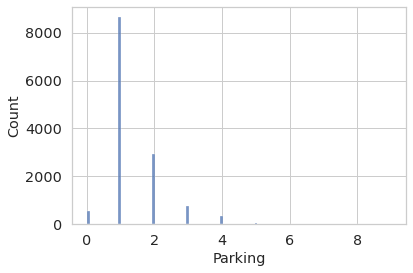

In [ ]:
sns.histplot(data=housing_pre, x='Parking')

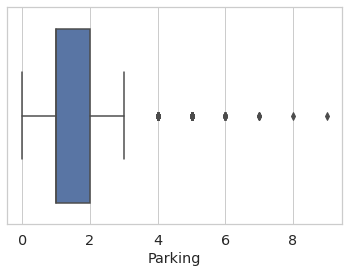

In [ ]:
sns.boxplot(data=housing_pre, x='Parking')

In [ ]:
housing_pre.query('Parking > 3').sort_values(by='Parking', ascending=False)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type,Latitude,Longitude
1457,25000.0,3320.0,222.0,4.0,5.0,4.0,9.0,1,0,1,0,Vila Mariana/São Paulo,rent,apartment,-23.593954,-46.639542
10422,25000.0,6000.0,600.0,4.0,5.0,4.0,8.0,0,0,0,0,Moema/São Paulo,rent,apartment,-23.610763,-46.657959
3082,16000.0,4800.0,425.0,5.0,6.0,5.0,7.0,0,0,1,0,Tatuapé/São Paulo,rent,apartment,-23.548995,-46.561935
3278,50000.0,5500.0,670.0,5.0,6.0,5.0,7.0,0,0,1,0,Campo Belo/São Paulo,rent,apartment,-23.625617,-46.674614
4503,25000.0,3700.0,266.0,3.0,4.0,3.0,7.0,0,0,1,0,Perdizes/São Paulo,rent,apartment,-23.500120,-46.627606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124,10000.0,1831.0,198.0,4.0,3.0,2.0,4.0,0,1,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.539096,-46.714576
4116,6900.0,4000.0,290.0,3.0,4.0,3.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.550768,-46.699608
4109,7000.0,2500.0,178.0,4.0,4.0,3.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.538858,-46.713225
4100,12000.0,2350.0,225.0,4.0,3.0,2.0,4.0,0,0,1,0,Alto de Pinheiros/São Paulo,rent,apartment,0.000000,0.000000


O número de vagas de estacionamento esta ligado ao valor de condomínio, e mesmo tendo outliers representam valores reais.

##2.8. Elevator, Furnished, Swimming_Pool, New

In [ ]:
housing_pre['Elevator'].unique()

array([0, 1])

In [ ]:
housing_pre['Furnished'].unique()

array([0, 1])

In [ ]:
housing_pre['Swimming_Pool'].unique()

array([0, 1])

In [ ]:
housing_pre['New'].unique()

array([0, 1])

Não há nenhuma alteração a ser realizada nesses atributos

##2.9. District

In [ ]:
#checando se todos os nomes de distrito estão corretos
housing_pre['District'].unique()

array(['Artur Alvim/São Paulo', 'Belém/São Paulo', 'Cangaíba/São Paulo',
       'Carrão/São Paulo', 'Cidade Líder/São Paulo',
       'Cidade Tiradentes/São Paulo', 'Ermelino Matarazzo/São Paulo',
       'Iguatemi/São Paulo', 'Itaim Paulista/São Paulo',
       'Itaquera/São Paulo', 'Jardim Helena/São Paulo',
       'José Bonifácio/São Paulo', 'Lajeado/São Paulo',
       'Parque do Carmo/São Paulo', 'Penha/São Paulo',
       'Ponte Rasa/São Paulo', 'Sapopemba/São Paulo',
       'São Lucas/São Paulo', 'São Mateus/São Paulo',
       'São Miguel/São Paulo', 'São Rafael/São Paulo',
       'Tatuapé/São Paulo', 'Vila Curuçá/São Paulo',
       'Vila Formosa/São Paulo', 'Vila Jacuí/São Paulo',
       'Vila Matilde/São Paulo', 'Vila Prudente/São Paulo',
       'Cambuci/São Paulo', 'Campo Belo/São Paulo',
       'Campo Grande/São Paulo', 'Campo Limpo/São Paulo',
       'Capão Redondo/São Paulo', 'Cidade Ademar/São Paulo',
       'Cidade Dutra/São Paulo', 'Cursino/São Paulo', 'Grajaú/São Paulo',
  

Como os dados são todos da cidade de São Paulo, a string '/São Paulo' será removida, mantendo somente o nome do Distrito.

In [ ]:
housing_pre['District'] = housing_pre['District'].str.replace('/São Paulo', '')

In [ ]:
#checando se as alterações foram feitas
housing_pre['District'].unique()

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

In [ ]:
#checando a quantidade de distritos que existem no dataset
len(housing_pre['District'].unique())

96

Aparentemente o dataset contempla dados de todos os distritos de São Paulo. Segundo  a [Prefeitura de São Paulo](https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php?p=12758) há 96 distritos na cidade.

##2.10. Negotiation_Type, Property_Type

In [ ]:
#checando se há outro tipo de negociação além de venda e aluguel
housing_pre['Negotiation_Type'].unique()

array(['rent', 'sale'], dtype=object)

In [ ]:
housing_pre['Property_Type'].unique()

array(['apartment'], dtype=object)

O atributo 'Property_Type' possui somente dados de apartamentos.

##2.11. Latitude, Longitude

In [ ]:
px.set_mapbox_access_token('pk.eyJ1IjoiZWRlbWlyYW5kYSIsImEiOiJjazMzaDNiZ3UwdWtoM2hwYXIxaHA0b3k2In0.ehkXWVxSDumAO5zeXSX2kA')
fig = px.scatter_mapbox(housing_pre, lat="Latitude", lon="Longitude", size_max=15, zoom=5, width=1000, height=800)
fig.show()

Analisando a localização através dos dados de Latitude e Longitude, nota-se que a há muitos erros de preenchimento, gerando localizações fora da cidade de São Paulo, é possível que em algumas instâncias os dados de Latitude e Longitude foram invertidos, outras instâncias tem esses valores zerados. 

Então para evitar erros de predição pelo modelo, serão gerados dois datasets, um dataset sem os dados de Latitude e Longitude, e outro dataset contendo somente instâncias com os dados de Latitude e Longitude da Cidade de São Paulo

In [ ]:
#gerando dataset sem os atributos Latitude e Longitude
housing_no_lat_lon = housing_pre.drop(columns=['Latitude', 'Longitude'])

In [ ]:
#calculando a mediana para localizar valores mais próximos da cidade de São Paulo
print(housing_pre['Latitude'].median())
print(housing_pre['Longitude'].median())

-23.55290125
-46.6376923


In [ ]:
housing_lat_lon_sp = housing_pre.query('Latitude < -23 and Latitude > -24 and Longitude < -46 and Longitude > -47')
fig = px.scatter_mapbox(housing_lat_lon_sp, lat="Latitude", lon="Longitude", size_max=15, zoom=5, width=1000, height=800)
fig.show()

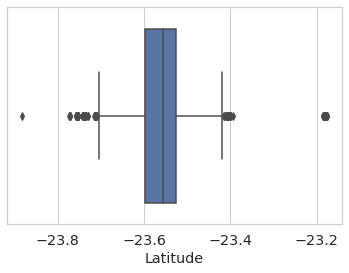

In [ ]:
sns.boxplot(data=housing_lat_lon_sp, x='Latitude')

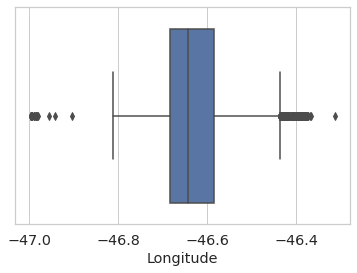

In [ ]:
sns.boxplot(data=housing_lat_lon_sp, x='Longitude')

Ainda existem alguns outliers para Latitude e Longitude, porém esses valores estão mais proximos da localização real dos imóveis. Se forem selecionados valores mais próximos da média de Latitude e Longitude, é provável que alguma parte da região territorial de São Paulo fique de fora, perdendo assim alguns dados necessários.

#4. Análise Exploratória

##4.1. Regiões com os valores de Alugueis mais altos (Mapa)

In [ ]:
fig = px.density_mapbox(housing_lat_lon_sp.query('Negotiation_Type == "rent"'), lat='Latitude', lon='Longitude', z='Price', 
                        radius=10, zoom=10, width=1000, height=800)
fig.show()

##4.2. Regiões com os valores de Venda mais altos (Mapa)

In [ ]:
fig = px.density_mapbox(housing_lat_lon_sp.query('Negotiation_Type == "sale"'), lat='Latitude', lon='Longitude', z='Price', 
                        radius=10, zoom=10, width=1000, height=800)
fig.show()

##4.3. Distritos com os valores mais altos para Venda e Aluguel

**Aluguel**

In [ ]:
housing_lat_lon_sp.query('Negotiation_Type == "rent"').groupby(['District']).mean().sort_values(by='Price', ascending=False).head(10)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,Latitude,Longitude
District,,,,,,,,,,,,,
Itaim Bibi,8739.383459,1860.060150,127.248120,2.127820,2.533835,1.375940,1.894737,0.315789,0.383459,0.609023,0.0,-23.584543,-46.677004
Iguatemi,8532.606061,805.393939,109.969697,2.121212,2.303030,1.090909,1.242424,0.272727,0.303030,0.090909,0.0,-23.589450,-46.674281
Alto de Pinheiros,7991.823529,2107.857143,167.949580,2.873950,2.882353,1.638655,2.386555,0.302521,0.159664,0.588235,0.0,-23.546233,-46.712206
Moema,7648.879747,1698.215190,137.683544,2.544304,2.651899,1.556962,2.063291,0.291139,0.284810,0.689873,0.0,-23.604399,-46.663441
Jardim Paulista,7308.645669,2103.850394,162.204724,2.669291,2.795276,1.503937,1.811024,0.362205,0.338583,0.377953,0.0,-23.566551,-46.658053
Campo Belo,6929.158730,1570.333333,143.587302,2.531746,3.039683,1.857143,2.317460,0.349206,0.380952,0.809524,0.0,-23.622856,-46.673185
Brooklin,6501.980000,1232.080000,111.430000,2.260000,2.740000,1.590000,1.900000,0.410000,0.510000,0.770000,0.0,-23.613390,-46.688072
Pinheiros,5825.920290,1258.818841,104.782609,2.246377,2.304348,1.173913,1.652174,0.340580,0.347826,0.528986,0.0,-23.560504,-46.683985
Vila Olimpia,5765.863636,1089.636364,74.363636,1.727273,2.613636,1.340909,1.522727,0.681818,0.568182,0.818182,0.0,-23.595879,-46.684714


**Venda**

In [ ]:
housing_lat_lon_sp.query('Negotiation_Type == "sale"').groupby(['District']).mean().sort_values(by='Price', ascending=False).head(10)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,Latitude,Longitude
District,,,,,,,,,,,,,
Iguatemi,3.665528e+06,467.650000,177.150000,3.050000,3.850000,2.200000,2.350000,0.500000,0.050000,0.450000,0.000000,-23.585596,-46.681983
Alto de Pinheiros,2.443442e+06,1382.250000,173.695652,3.065217,3.173913,1.891304,2.619565,0.489130,0.065217,0.695652,0.010870,-23.546908,-46.710279
Itaim Bibi,1.896582e+06,1692.166667,131.583333,2.430556,2.652778,1.430556,1.791667,0.472222,0.208333,0.527778,0.000000,-23.584074,-46.676550
Jardim Paulista,1.737930e+06,1716.633803,143.464789,2.746479,2.746479,1.267606,1.549296,0.521127,0.126761,0.239437,0.014085,-23.568660,-46.658574
Vila Olimpia,1.642423e+06,716.461538,105.358974,2.512821,2.923077,1.717949,1.897436,0.692308,0.230769,0.692308,0.000000,-23.598507,-46.679572
Moema,1.575049e+06,1404.967213,124.868852,2.655738,2.770492,1.491803,2.057377,0.377049,0.204918,0.655738,0.008197,-23.604763,-46.664257
Campo Belo,1.382537e+06,1199.489796,127.673469,2.653061,3.122449,1.795918,2.265306,0.591837,0.142857,0.938776,0.040816,-23.615167,-46.668727
Brooklin,1.314623e+06,1041.798450,121.054264,2.627907,2.891473,1.666667,2.062016,0.333333,0.124031,0.744186,0.007752,-23.613113,-46.684808
Vila Madalena,1.235416e+06,816.634146,100.804878,2.487805,2.609756,1.365854,1.634146,0.731707,0.097561,0.707317,0.048780,-23.550483,-46.692531


Os distritos com valores mais altos tanto para venda quanto para aluguel não se diferem muito 

##4.4. Distritos com o metro quadrado mais caro para Aluguel e Venda

In [ ]:
housing_lat_lon_sp_m2 = housing_lat_lon_sp.copy()
housing_lat_lon_sp_m2['m2'] = housing_lat_lon_sp.apply(lambda row: row.Price/row.Size, axis = 1)
housing_lat_lon_sp_m2.query('Negotiation_Type == "rent"').groupby(['District']).mean().sort_values(by='m2', ascending=False).head(10)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,Latitude,Longitude,m2
District,,,,,,,,,,,,,,
Iguatemi,8532.606061,805.393939,109.969697,2.121212,2.303030,1.090909,1.242424,0.272727,0.303030,0.090909,0.0,-23.589450,-46.674281,83.215784
Vila Olimpia,5765.863636,1089.636364,74.363636,1.727273,2.613636,1.340909,1.522727,0.681818,0.568182,0.818182,0.0,-23.595879,-46.684714,80.081521
Itaim Bibi,8739.383459,1860.060150,127.248120,2.127820,2.533835,1.375940,1.894737,0.315789,0.383459,0.609023,0.0,-23.584543,-46.677004,74.508815
Brooklin,6501.980000,1232.080000,111.430000,2.260000,2.740000,1.590000,1.900000,0.410000,0.510000,0.770000,0.0,-23.613390,-46.688072,61.750354
Pinheiros,5825.920290,1258.818841,104.782609,2.246377,2.304348,1.173913,1.652174,0.340580,0.347826,0.528986,0.0,-23.560504,-46.683985,61.265647
Consolação,4147.291667,872.583333,77.958333,1.635417,1.875000,0.739583,1.072917,0.322917,0.343750,0.531250,0.0,-23.550801,-46.653493,58.394525
Vila Madalena,4699.507692,1286.384615,99.138462,2.015385,2.600000,1.292308,1.676923,0.523077,0.200000,0.523077,0.0,-23.550293,-46.693495,54.580293
Moema,7648.879747,1698.215190,137.683544,2.544304,2.651899,1.556962,2.063291,0.291139,0.284810,0.689873,0.0,-23.604399,-46.663441,53.574603
Campo Belo,6929.158730,1570.333333,143.587302,2.531746,3.039683,1.857143,2.317460,0.349206,0.380952,0.809524,0.0,-23.622856,-46.673185,51.765064


In [ ]:
housing_lat_lon_sp_m2.query('Negotiation_Type == "sale"').groupby(['District']).mean().sort_values(by='m2', ascending=False).head(10)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,Latitude,Longitude,m2
District,,,,,,,,,,,,,,
Iguatemi,3.665528e+06,467.650000,177.150000,3.050000,3.850000,2.200000,2.350000,0.500000,0.050000,0.450000,0.000000,-23.585596,-46.681983,17102.299463
Vila Olimpia,1.642423e+06,716.461538,105.358974,2.512821,2.923077,1.717949,1.897436,0.692308,0.230769,0.692308,0.000000,-23.598507,-46.679572,14467.924708
Itaim Bibi,1.896582e+06,1692.166667,131.583333,2.430556,2.652778,1.430556,1.791667,0.472222,0.208333,0.527778,0.000000,-23.584074,-46.676550,14250.291425
Alto de Pinheiros,2.443442e+06,1382.250000,173.695652,3.065217,3.173913,1.891304,2.619565,0.489130,0.065217,0.695652,0.010870,-23.546908,-46.710279,12518.306398
Vila Madalena,1.235416e+06,816.634146,100.804878,2.487805,2.609756,1.365854,1.634146,0.731707,0.097561,0.707317,0.048780,-23.550483,-46.692531,12048.614872
Jardim Paulista,1.737930e+06,1716.633803,143.464789,2.746479,2.746479,1.267606,1.549296,0.521127,0.126761,0.239437,0.014085,-23.568660,-46.658574,11693.696635
Moema,1.575049e+06,1404.967213,124.868852,2.655738,2.770492,1.491803,2.057377,0.377049,0.204918,0.655738,0.008197,-23.604763,-46.664257,11622.997522
Pinheiros,9.191016e+05,707.868132,80.428571,2.065934,1.879121,0.824176,1.296703,0.461538,0.087912,0.615385,0.032967,-23.559736,-46.682808,11590.659658
Brooklin,1.314623e+06,1041.798450,121.054264,2.627907,2.891473,1.666667,2.062016,0.333333,0.124031,0.744186,0.007752,-23.613113,-46.684808,10894.759882


O distrito Iguatemi aparece em todas as análises de preço entre os primeiros colocados, evidenciando que este é um dos distritos mais caros para morar na cidade de São Paulo

##4.5. Procurando por Correlações

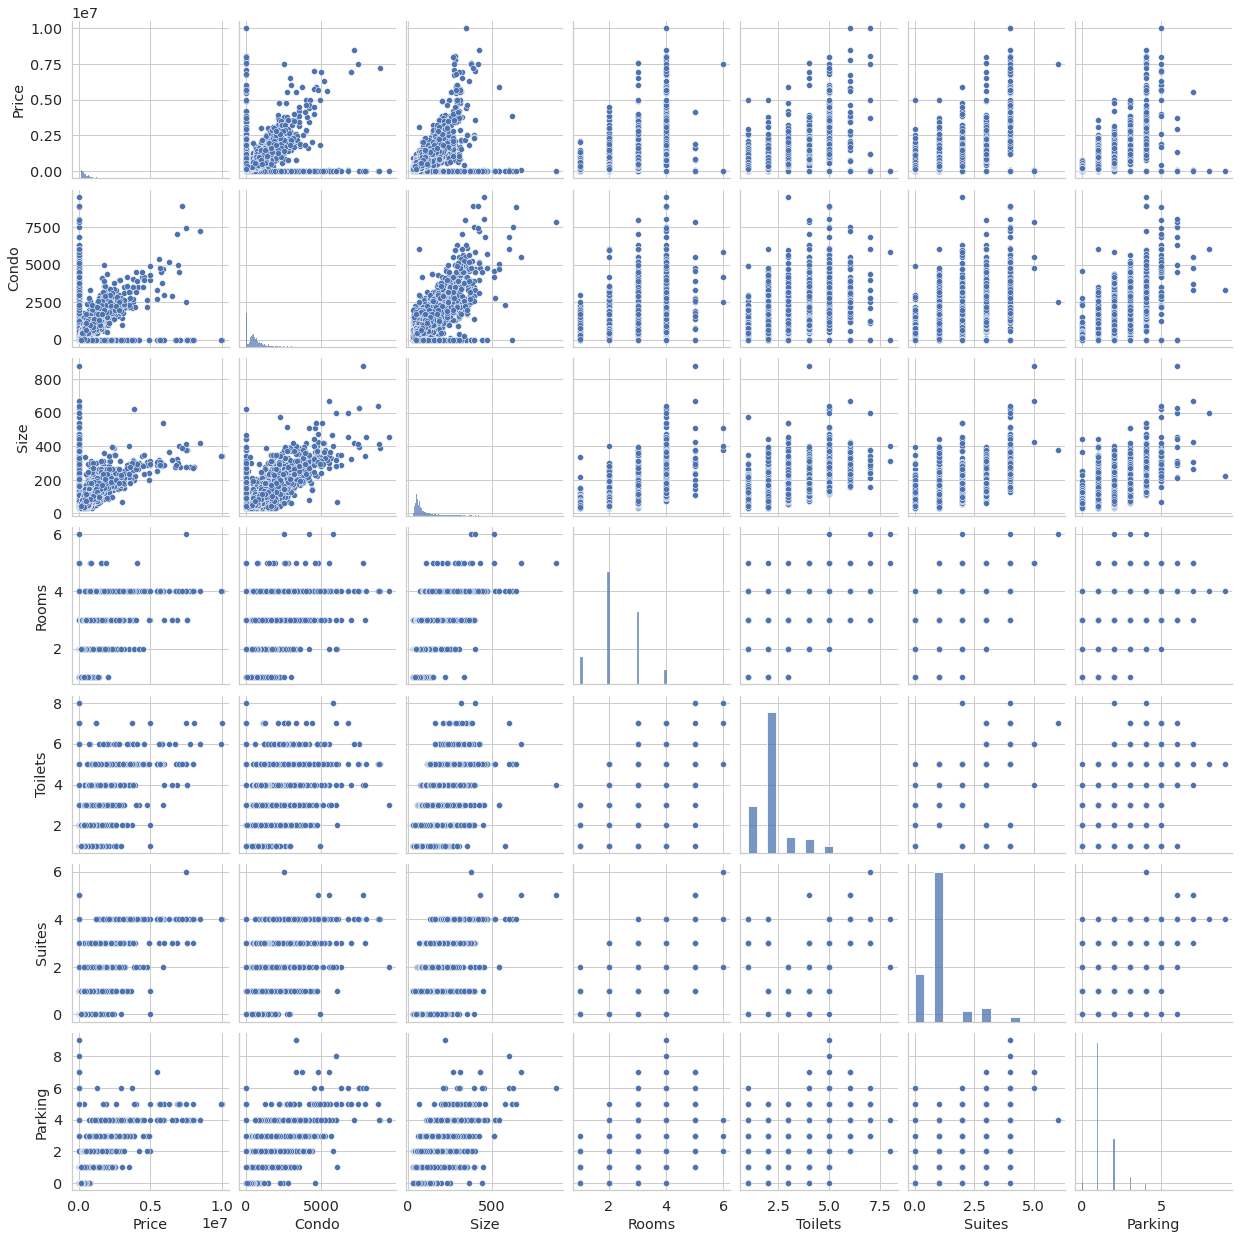

In [ ]:
sns.pairplot(data=housing_lat_lon_sp[['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']])

**Analisando o índice de correlação utilizando o dataset com dados de Venda e Aluguel**

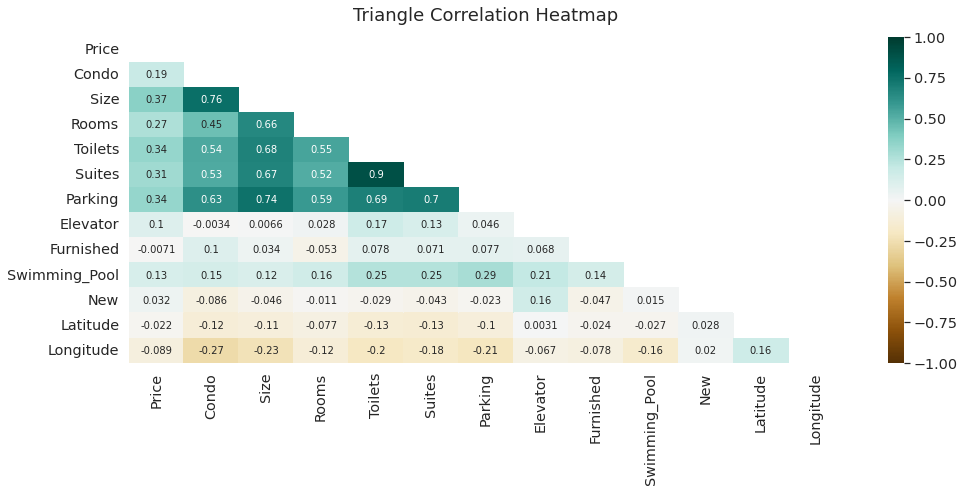

In [ ]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(housing_lat_lon_sp.corr(), dtype=np.bool))  # cria uma matriz triangular beseado na matriz de correlação do pandas

heatmap = sns.heatmap(housing_lat_lon_sp.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

**Analisando o índice de correlação utilizando somente os dados de Venda**

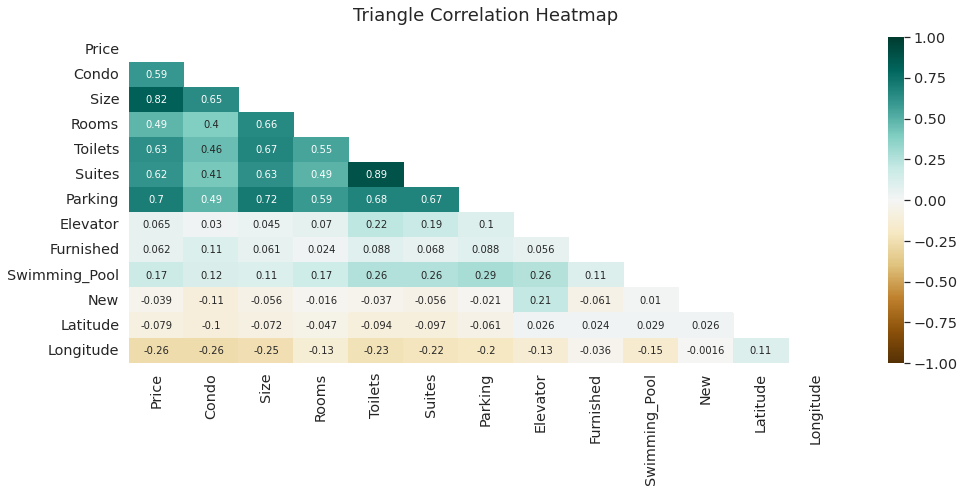

In [ ]:
# plotando o coeficiente de correlação como uma heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(housing_lat_lon_sp.query('Negotiation_Type == "sale"').corr(), dtype=np.bool))  # cria uma matriz triangular beseado na matriz de correlação do pandas

heatmap = sns.heatmap(housing_lat_lon_sp.query('Negotiation_Type == "sale"').corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Nota-se que quando utilizado o dataset com dados de Aluguel e Venda os índices de correlação para o atributo 'Price' caem muito em comparação com o dataset de somente Venda

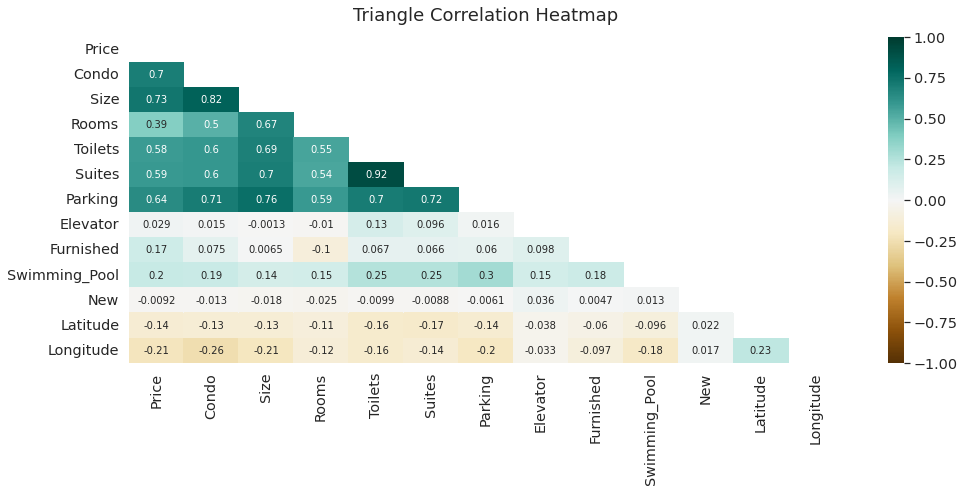

In [ ]:
# plotando o coeficiente de correlação como uma heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(housing_lat_lon_sp.query('Negotiation_Type == "rent"').corr(), dtype=np.bool))  # cria uma matriz triangular beseado na matriz de correlação do pandas

heatmap = sns.heatmap(housing_lat_lon_sp.query('Negotiation_Type == "rent"').corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

O mesmo acontece para o dataset contendo somente dados de Aluguel

In [ ]:
#checando os atributos com maiores correlações com Price
housing_lat_lon_sp.query('Negotiation_Type == "sale"').corr()["Price"].sort_values(ascending=False)

Price            1.000000
Size             0.823944
Parking          0.700818
Toilets          0.631339
Suites           0.615929
Condo            0.594537
Rooms            0.485608
Swimming_Pool    0.172693
Elevator         0.065156
Furnished        0.062409
New             -0.038784
Latitude        -0.079459
Longitude       -0.262528
Name: Price, dtype: float64

In [ ]:
#checando os atributos com maiores correlações com Price
housing_lat_lon_sp.query('Negotiation_Type == "rent"').corr()["Price"].sort_values(ascending=False)

Price            1.000000
Size             0.734215
Condo            0.699753
Parking          0.642396
Suites           0.586365
Toilets          0.580549
Rooms            0.390459
Swimming_Pool    0.201620
Furnished        0.168287
Elevator         0.028727
New             -0.009212
Latitude        -0.135840
Longitude       -0.211983
Name: Price, dtype: float64

Em ambos os casos tanto para Aluguel e Venda o atributo que apresenta maior correlação com 'Price' é o atributo 'Size'

**Analisando a correlação entre os dois atributos em um scatterplot**

**Aluguel**

In [ ]:
#checando o valor maximo para gerar os yticks
housing_lat_lon_sp.query('Negotiation_Type == "rent"')['Price'].max()

50000.0

<Figure size 1080x576 with 0 Axes>

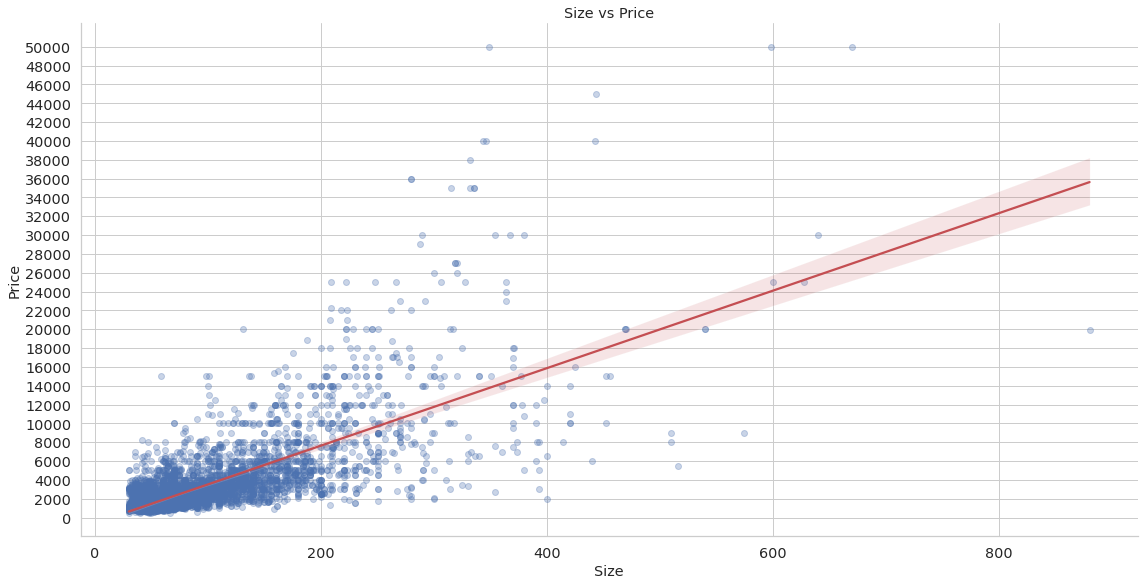

In [ ]:
plt.figure(figsize=(15, 8))
sns.lmplot(data=housing_lat_lon_sp.query('Negotiation_Type == "rent"'), 
           x="Size", y="Price", aspect=2, height=8, scatter_kws={'alpha': 0.3}, line_kws={'color': 'r'})
plt.yticks(range(0, 50001, 2000))
plt.grid(True)
plt.title('Size vs Price')
display()

**Venda**

In [ ]:
#checando o valor maximo para gerar os yticks
housing_lat_lon_sp.query('Negotiation_Type == "sale"')['Price'].max()

10000000.0

<Figure size 1080x576 with 0 Axes>

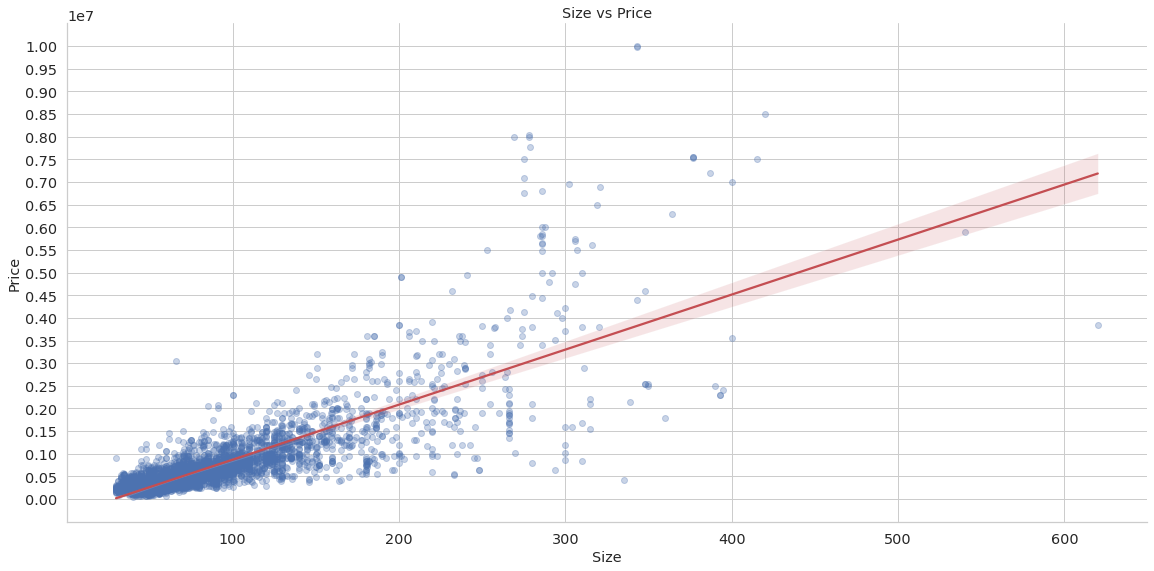

In [ ]:
plt.figure(figsize=(15, 8))
sns.lmplot(data=housing_lat_lon_sp.query('Negotiation_Type == "sale"'), 
           x="Size", y="Price", aspect=2, height=8, scatter_kws={'alpha': 0.3}, line_kws={'color': 'r'})
plt.yticks(range(0, 10000001, 500000))
plt.grid(True)
plt.title('Size vs Price')
display()

É possível notar uma forte correlação entre 'Size' e 'Price', como mostra o scatterplot

##4.6. Distribuição dos dados

In [ ]:
housing_lat_lon_sp.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming_Pool', 'New', 'District',
       'Negotiation_Type', 'Property_Type', 'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
numeric_attributes = housing_lat_lon_sp.columns.drop(['Elevator', 'Furnished', 'Swimming_Pool', 'New', 'District',
       'Negotiation_Type', 'Property_Type', 'Latitude', 'Longitude'])
numeric_attributes

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking'], dtype='object')

In [ ]:
len(numeric_attributes)

7

**Boxplot dos atributos númericos para os casos de imóveis alugados**

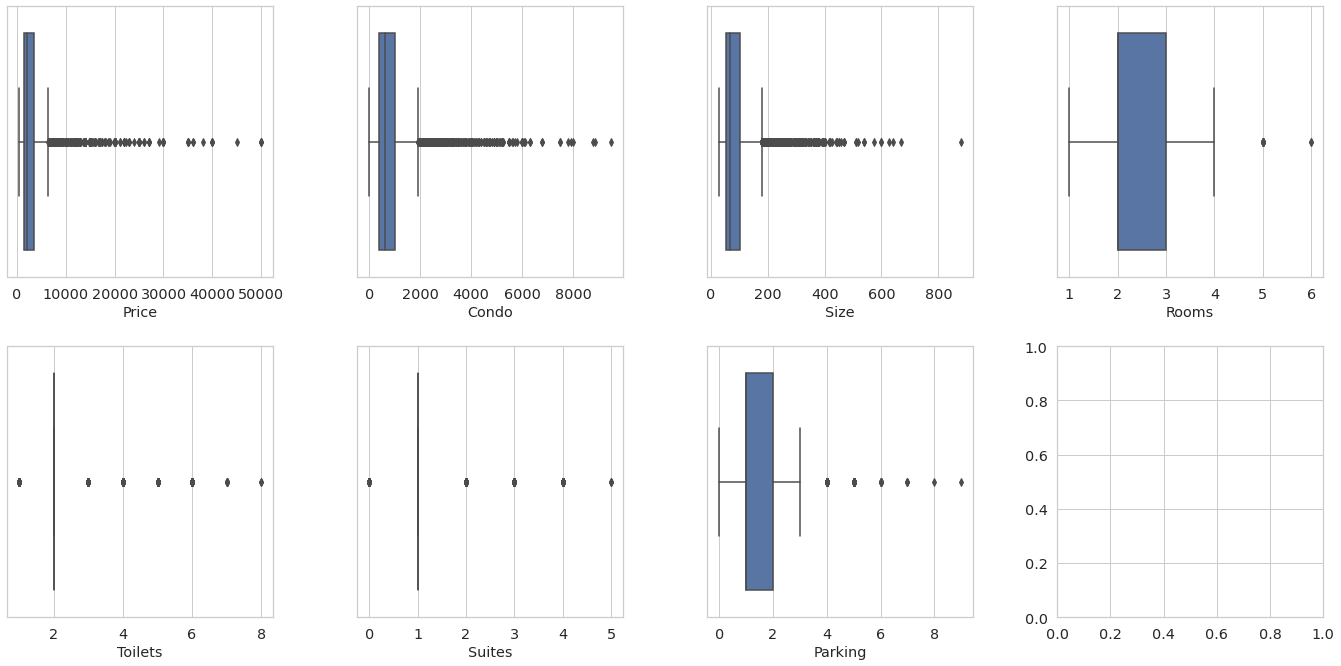

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 4
    col = i % 4
    sns.boxplot(data=housing_lat_lon_sp.query('Negotiation_Type == "rent"'), x=attr, ax=axes[row, col])

**Boxplot dos atributos númericos para os casos de imóveis a venda**

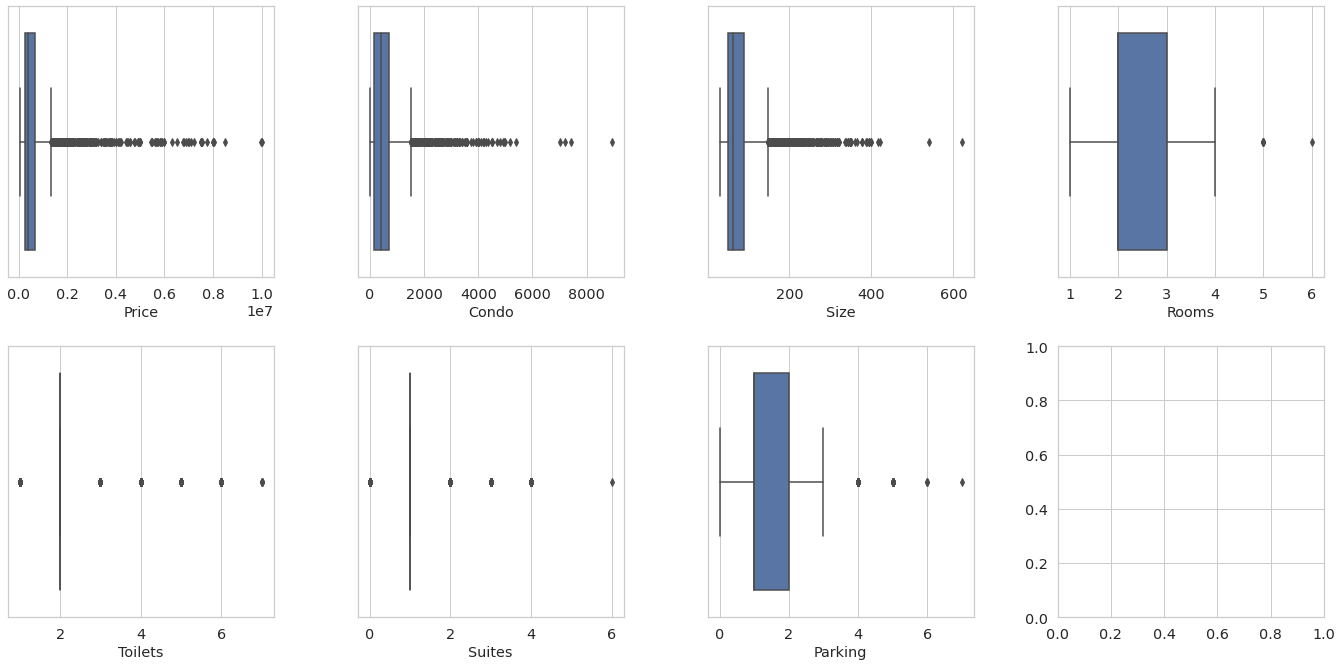

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 4
    col = i % 4
    sns.boxplot(data=housing_lat_lon_sp.query('Negotiation_Type == "sale"'), x=attr, ax=axes[row, col])

**Histograma dos atributos númericos para os casos de imóveis alugados**

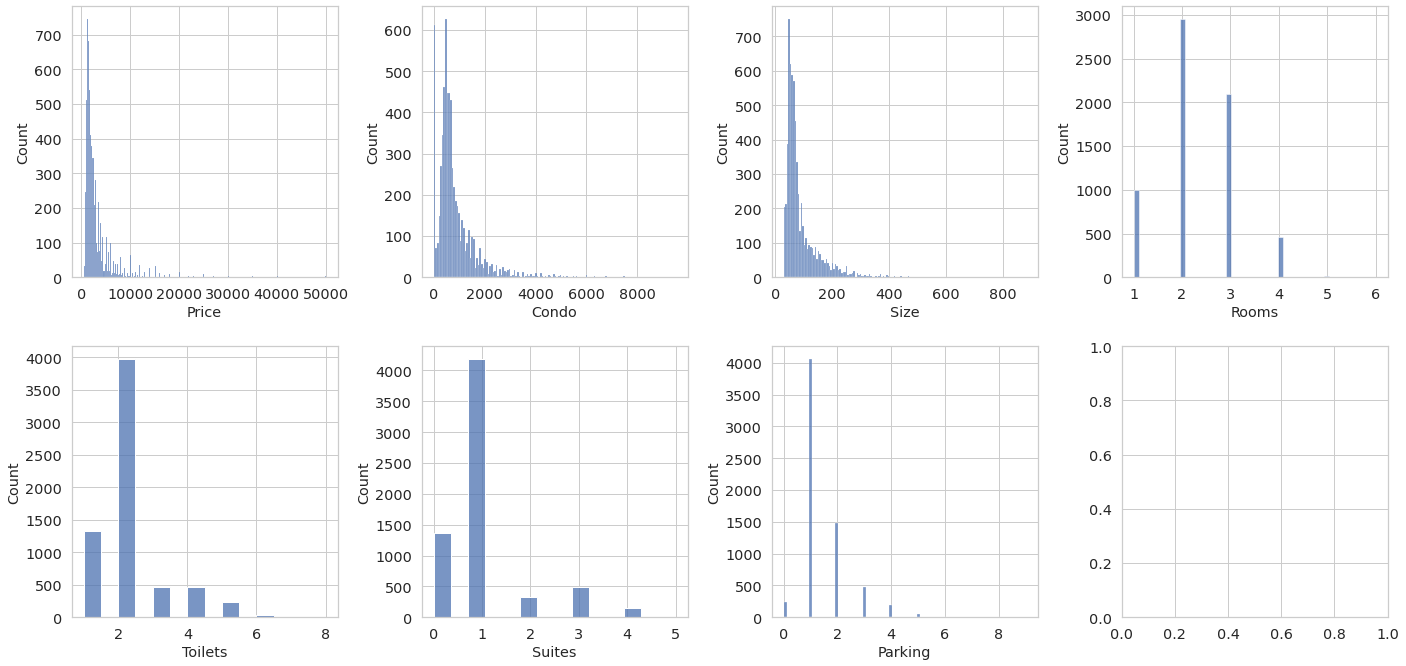

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 4
    col = i % 4
    sns.histplot(data=housing_lat_lon_sp.query('Negotiation_Type == "rent"'), x=attr, ax=axes[row, col])

**Histograma dos atributos númericos para os casos de imóveis a venda**

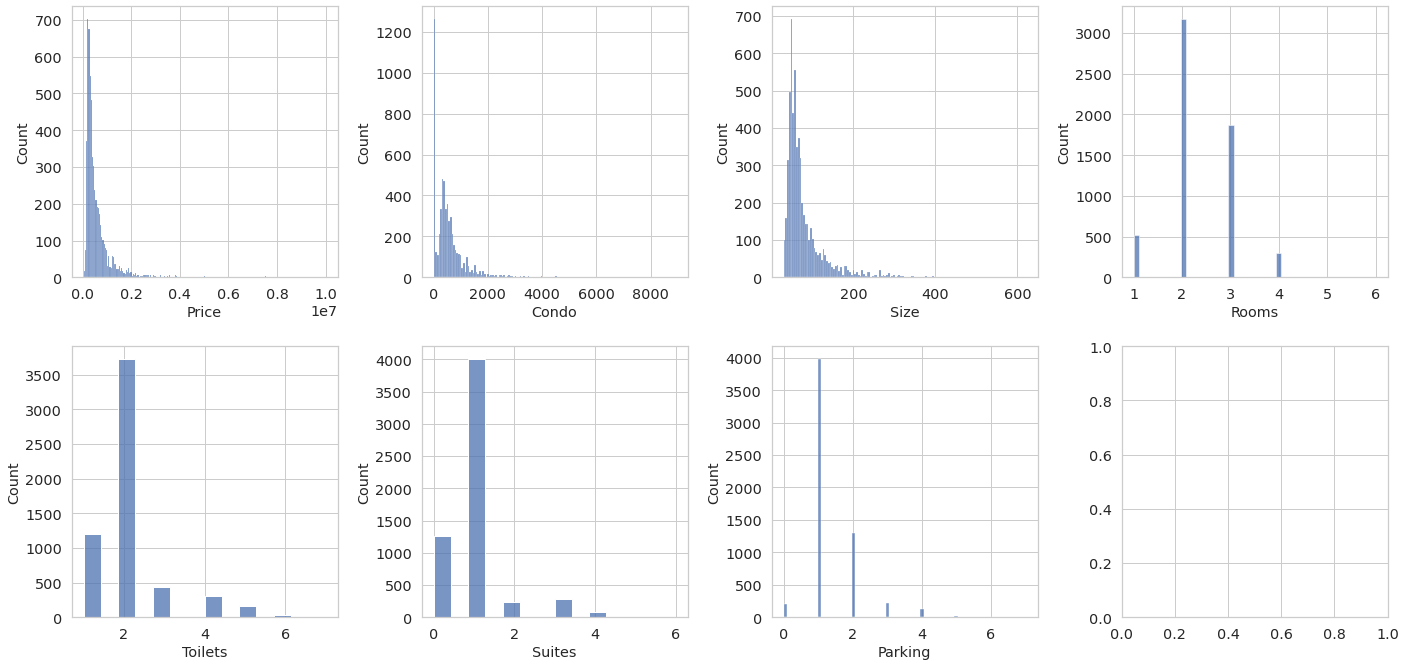

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 4
    col = i % 4
    sns.histplot(data=housing_lat_lon_sp.query('Negotiation_Type == "sale"'), x=attr, ax=axes[row, col])

#5. Modelos

Após a conclusão das etapas de limpeza e análise dos dados que compõem o dataset, dividiu-se o dataframe já tratado em 2 sub conjuntos de dados, usando o critério de tipo de negociação como divisor, com o intúito de criar um modelo mais performático e específico para aluguel do imóvel e outro para a compra do imóvel.

In [ ]:
df_rent =  housing_no_lat_lon.query('Negotiation_Type == "rent"')
df_sale =  housing_no_lat_lon.query('Negotiation_Type == "sale"')

In [ ]:
df_rent.head(5)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type
0,930.0,220.0,47.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim,rent,apartment
1,1000.0,148.0,45.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim,rent,apartment
2,1000.0,100.0,48.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim,rent,apartment
3,1000.0,200.0,48.0,2.0,2.0,1.0,1.0,0,0,0,0,Artur Alvim,rent,apartment
4,1300.0,410.0,55.0,2.0,2.0,1.0,1.0,1,0,0,0,Artur Alvim,rent,apartment


In [ ]:
df_sale.head(5)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming_Pool,New,District,Negotiation_Type,Property_Type
4747,732600.0,1000.0,74.0,1.0,2.0,1.0,2.0,1,0,1,0,Vila Madalena,sale,apartment
4748,1990000.0,2400.0,164.0,4.0,5.0,2.0,3.0,1,1,1,0,Vila Madalena,sale,apartment
4749,720000.0,700.0,70.0,2.0,2.0,1.0,1.0,1,0,1,1,Vila Madalena,sale,apartment
4750,1680000.0,1580.0,155.0,3.0,5.0,3.0,2.0,1,0,1,0,Vila Madalena,sale,apartment
4751,1200000.0,900.0,56.0,2.0,2.0,1.0,2.0,0,1,1,0,Vila Madalena,sale,apartment


Com o íntuito de desenvolver um sistema capaz de prever o valor do imóvel, utilizou-se a biblioteca skleanr, a qual possui muitos modelos já existentes de aprendizado de máquina, tendo seu projeto iniciado em 2007 como um projeto Google Summer of Code de David Cournapeau.

Fonte: [Sckit-Learn](https://scikit-learn.org/stable/about.html)

Com a divisão já realizada, não se faz necessário a utlização do dado *Negotiation_Type*, além do *Property_Type*, uma vez que no capítulo 2.10 fica evidente que o conjunto de dados contém apenas apartamentos.

In [ ]:
df_rent.drop(columns=['Negotiation_Type','Property_Type'], inplace=True)
df_sale.drop(columns=['Negotiation_Type','Property_Type'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Após a remoção dos dados não utilizados, o primeiro passo foi transformar os dados da coluna *District*, a qual possui dados do tipo texto, em dados do tipo numérico. Para isso, optou-se na utilização do método *One Hot Enconding*, utilizando a função *Pipeline*, além do *Simple Imputer* e do *Robust Scaler* para os dados numéricos.



In [ ]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

num_attributes = ['Condo','Size','Rooms','Toilets','Suites','Parking','Elevator','Furnished','Swimming_Pool','New']
cat_attributes = ['District']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=0))
])

cat_pipeline = Pipeline([
    ('label-encoding', ModifiedLabelEncoder())
])

preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes),
    ('categorical', cat_pipeline, cat_attributes)
])

num_attributes = ['Condo','Size','Rooms','Toilets','Suites','Parking','Elevator','Furnished','Swimming_Pool','New']
cat_attributes = ['District']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=0))
])

cat_pipeline = Pipeline([
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes),
    ('categorical', cat_pipeline, cat_attributes)
])

In [ ]:
df_sale_processed = preprocessed_pipeline.fit_transform(df_sale)
df_rent_processed = preprocessed_pipeline.fit_transform(df_rent)

In [ ]:
df_sale_processed = pd.DataFrame(df_sale_processed.toarray())
df_rent_processed = pd.DataFrame(df_rent_processed.toarray())

A segunda etapa se deu em realizar a divisão de cada dataframe em dois arrays, sendo eles, previsores, o qual possui as entradas do dataset, e as classes, que indica a saida, como comentado anteriormente.

Após essa etapa, utilizou-se a função train test split para dividir cada dataset em duas parte, sendo elas o conjunto de treino, o qual represente 70% do total de amostras, e o conjunto de teste, com 30% do total.

In [ ]:
atributos_rent = df_rent_processed.iloc[:,1:103].values
preco_rent = df_rent.iloc[:,0:1].values

X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(atributos_rent, preco_rent, test_size=0.3, random_state=2)

atributos_sale = df_sale_processed.iloc[:,1:103].values
preco_sale = df_sale.iloc[:,0:1].values

X_train_sale, X_test_sale, y_train_sale, y_test_sale = train_test_split(atributos_sale, preco_sale, test_size=0.3, random_state=2)

Com a conclusão das etapas iniciais, gerou-se três modelos diferentes de aprendizado de máquina, sendo eles um KNN, uma Regressão Linear e uma Árvore de Decisão, além de um modelo de Multilayer Perceptron (MLP) simples, com o intiito de analisar qual o modelo que melhor performou com o conjunto de dados apresentados, além de utilizar a função cross_validade, a qual realiza a validação cruzada dos dados de treino e teste, aumentando ainda mais os resultados dos modelos.

Para comparar os modelos, utilizou-se métricas de avaliação como parâmetro, sendo elas a *Root Mean Square Error* (RMSE), R2, o qual mostra o quanto o modelo explica/ se ajusta aos dados, *Mean Average Error* (MAE) e *Mean Squared Log Error* (MSLE), exibindo seus valores tanto antes da realização da validação cruzada, quanto após sua utilização.

In [ ]:
def processamento(nome, modelo, X_train, X_test, y_train, y_test, atributos, preco):
    print(nome)
    modelo.fit(X_train, y_train)
    previsoes = modelo.predict(X_test)

    print('Resultados sem cross validation')
    rmse = mean_squared_error(previsoes, y_test.ravel(), squared=False)
    print('rmse: ',abs(rmse))
    r2 = r2_score(previsoes, y_test.ravel())
    print('r2_score ', abs(r2))
    mae = mean_absolute_error(previsoes, y_test.ravel())
    print('mae ', abs(mae))
    # msle = mean_squared_log_error(previsoes, y_test.ravel())
    # print('msle ', msle)


    scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
    cv_results = cross_validate(modelo, atributos, preco.ravel(), cv = 10, scoring = scoring)

    
    test_neg_root_mean_squared_error = np.median(cv_results['test_neg_root_mean_squared_error'])
    test_neg_mean_absolute_error = np.median(cv_results['test_neg_mean_absolute_error'])

    cv_rmse = abs(test_neg_root_mean_squared_error)
    cv_r2 = abs(cv_results['test_r2'].max())
    cv_mae = abs(test_neg_mean_absolute_error)
 
    print('Resultados com cross validation:')
    print('   rmse: ', cv_rmse)
    print('   r2: ', cv_r2)
    print('   mae: ', cv_mae)
    # print('   msle: ', cv_results['test_neg_mean_squared_log_error'].min())
    print('\n')

    return(previsoes, rmse, r2, mae, cv_rmse, cv_r2, cv_mae)


modelos = []
modelos.append(('knn_reg', KNeighborsRegressor(n_neighbors=5)))
modelos.append(('lin_reg', LinearRegression()))
modelos.append(('tree', DecisionTreeRegressor(max_depth=100)))
modelos.append(('mlp', MLPRegressor(learning_rate_init = 0.2, learning_rate = 'adaptive', hidden_layer_sizes=(52,4))))

resultados = []
print('########### Rent #############')
for nome, modelo in modelos:
  previsoes, rmse, r2, mae, cv_rmse, cv_r2, cv_mae  = processamento(nome, modelo, X_train_rent, X_test_rent, y_train_rent, y_test_rent, atributos_rent, preco_rent)
  
  resultados.append(('rent', nome, rmse, r2, mae, cv_rmse, cv_r2, cv_mae, previsoes))

print('\n')
print('########### Sale #############')
for nome, modelo in modelos:
  previsoes, rmse, r2, mae, cv_rmse, cv_r2, cv_mae  = processamento(nome, modelo, X_train_sale, X_test_sale, y_train_sale, y_test_sale, atributos_sale, preco_sale)
  
  resultados.append(('sale', nome, rmse, r2, mae, cv_rmse, cv_r2, cv_mae, previsoes))



########### Rent #############
knn_reg
Resultados sem cross validation
rmse:  2250.920552409027
r2_score  0.3788761685681111
mae  1043.2499525166193
Resultados com cross validation:
   rmse:  2114.6615884278626
   r2:  0.6472821891309453
   mae:  1096.948148148148


lin_reg
Resultados sem cross validation
rmse:  1992.5974321148851
r2_score  0.5563426539682448
mae  1023.5146577115978
Resultados com cross validation:
   rmse:  1703.6658024861526
   r2:  0.7217019947170353
   mae:  989.5884772642434


tree
Resultados sem cross validation
rmse:  2650.792834695587
r2_score  0.4202943495529671
mae  999.8250271333604
Resultados com cross validation:
   rmse:  2234.27566558354
   r2:  0.6977769152740421
   mae:  979.6058955704789


mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Resultados sem cross validation
rmse:  1773.109783974151
r2_score  0.6675946016148304
mae  820.5612893379674
Resultados com cross validation:
   rmse:  1595.634809990942
   r2:  0.8027918461786043
   mae:  798.4266803415243




########### Sale #############
knn_reg
Resultados sem cross validation
rmse:  368439.3205815116
r2_score  0.714865896002838
mae  159468.40306716025
Resultados com cross validation:
   rmse:  352408.2840554577
   r2:  0.7572875636117263
   mae:  161796.54984126982


lin_reg
Resultados sem cross validation
rmse:  316078.2702677778
r2_score  0.7863227051658841
mae  168709.27985118038
Resultados com cross validation:
   rmse:  270792.0688519745
   r2:  0.8059652368984085
   mae:  160671.20225491625


tree
Resultados sem cross validation
rmse:  285739.69931511435
r2_score  0.8184796919894768
mae  132110.11329209307
Resultados com cross validation:
   rmse:  348815.725897607
   r2:  0.8423527304679801
   mae:  135394.60326470717


mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Resultados sem cross validation
rmse:  308480.34967132774
r2_score  0.7649732068528978
mae  162953.37522836158
Resultados com cross validation:
   rmse:  233382.10701918794
   r2:  0.888214436001131
   mae:  121071.10875104915




# 6. Resultados

Para analisar o desempenho dos modelos criados, gerou-se um dataframe com os valores obtidos de desempenho com e sem validação cruzada ordenando-os pelo maior valor de R2.

In [ ]:
df_resultados = pd.DataFrame(resultados,
                  columns = ['Negotiaion_Type','Modelo','RMSE', 'R2', 'MAE', 'CV_RMSE', 'CV_R2', 'CV_MAE', 'previsoes'])

df_resultados = pd.DataFrame(resultados,
                  columns = ['Negotiaion_Type','Modelo','RMSE', 'R2', 'MAE', 'CV_RMSE', 'CV_R2', 'CV_MAE', 'previsoes'],
                  index = df_resultados['Modelo'])

df_resultados.drop(columns=['Modelo', 'previsoes'], inplace=True)

df_resultados = df_resultados.sort_values(by=['Negotiaion_Type', 'CV_R2'], ascending=False)

df_resultados

,Negotiaion_Type,RMSE,R2,MAE,CV_RMSE,CV_R2,CV_MAE
Modelo,,,,,,,
mlp,sale,308480.349671,0.764973,162953.375228,233382.107019,0.888214,121071.108751
tree,sale,285739.699315,0.818480,132110.113292,348815.725898,0.842353,135394.603265
lin_reg,sale,316078.270268,0.786323,168709.279851,270792.068852,0.805965,160671.202255
knn_reg,sale,368439.320582,0.714866,159468.403067,352408.284055,0.757288,161796.549841
mlp,rent,1773.109784,0.667595,820.561289,1595.634810,0.802792,798.426680
lin_reg,rent,1992.597432,0.556343,1023.514658,1703.665802,0.721702,989.588477
tree,rent,2650.792835,0.420294,999.825027,2234.275666,0.697777,979.605896
knn_reg,rent,2250.920552,0.378876,1043.249953,2114.661588,0.647282,1096.948148


## 6.1 Exibição dos resultados de negociação do tipo venda

Com intuito de exibir os resultados das previsões dos modelos, plotou-se 4 gráficos para cada tipo de negociação, exibindo os dados de treino, teste e os previstos por cada modelo, sendo exibidos abaixo.

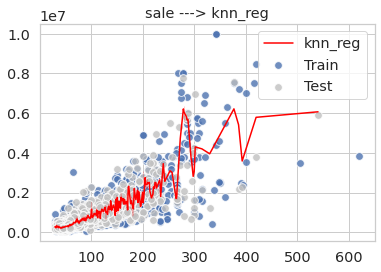

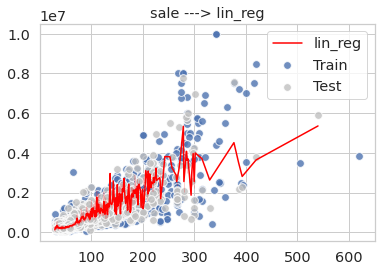

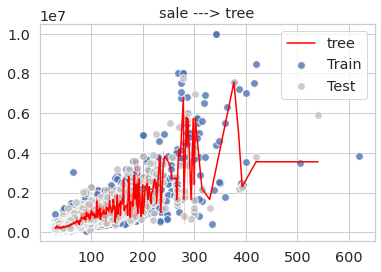

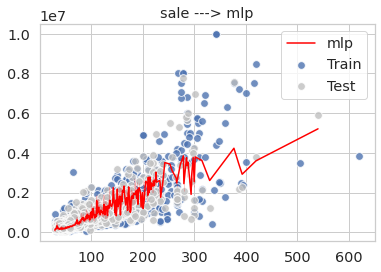

In [ ]:
for tipo, nome, rmse, r2, mae, cv_rmse, cv_r2, cv_mae, previsoes in resultados:
  if tipo == 'sale':
    fig = plt.subplots(1)
    sns.scatterplot(x=X_train_sale[0:5000,0], y=y_train_sale[0:5000].ravel(), s=60, linewidth=1, alpha=0.8, label='Train')
    sns.scatterplot(x=X_test_sale[0:5000, 0], y=y_test_sale[0:5000].ravel(), s=60, linewidth=1, alpha=0.8, color='silver', label='Test')
    sns.lineplot(x=X_test_sale[:, 0], y=previsoes[:].ravel(), color='red', label=nome)
    plt.title(tipo + ' ---> ' + nome)
    plt.plot()

Dividiu-se os resultados dos modelos de venda em 2 sub dataframes para melhor compara-los

In [ ]:
df_resultados_sale = df_resultados.query('Negotiaion_Type == "sale"')

df_sem_cross = df_resultados_sale[['RMSE', 'R2', 'MAE']].sort_values(by=['R2'], ascending=False)
print(df_sem_cross)

df_cross = df_resultados_sale[['CV_RMSE', 'CV_R2', 'CV_MAE']].sort_values(by=['CV_R2'], ascending=False)
print(df_cross)

                  RMSE        R2            MAE
Modelo                                         
tree     285739.699315  0.818480  132110.113292
lin_reg  316078.270268  0.786323  168709.279851
mlp      308480.349671  0.764973  162953.375228
knn_reg  368439.320582  0.714866  159468.403067
               CV_RMSE     CV_R2         CV_MAE
Modelo                                         
mlp      233382.107019  0.888214  121071.108751
tree     348815.725898  0.842353  135394.603265
lin_reg  270792.068852  0.805965  160671.202255
knn_reg  352408.284055  0.757288  161796.549841


Apenas para melhor visualizar os resultados obtidos, normalizou-se de 0 à 1 os valores obtidos tanto do RMSE quanto do MAE e plotou-se os gráficos dos quatros modelos com as três métricas analisadas.

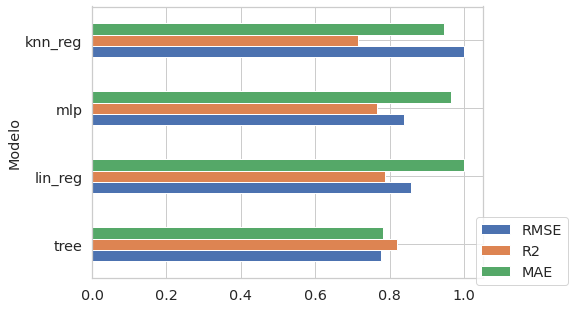

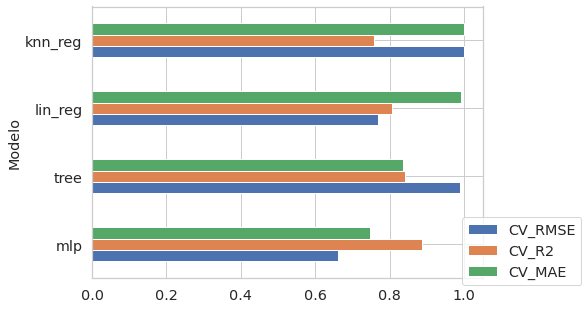

In [ ]:
df_sem_cross[['RMSE']] = df_sem_cross[['RMSE']]/(df_sem_cross[['RMSE']].max())
df_sem_cross[['MAE']] = df_sem_cross[['MAE']]/(df_sem_cross[['MAE']].max())

df_cross[['CV_RMSE']] = df_cross[['CV_RMSE']]/(df_cross[['CV_RMSE']].max())
df_cross[['CV_MAE']] = df_cross[['CV_MAE']]/(df_cross[['CV_MAE']].max())

df_sem_cross.plot(kind='barh', legend=True, figsize=(7,5))
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.1))
df_cross.plot(kind='barh', legend=True, figsize=(7,5))
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.1))

## 6.2 Exibição dos resultados de negociação do tipo locação

Assim como na seção 6.1, plotou-se 4 gráficos, um para cada modelo, exibindo os dados de treino, teste e os previstos, sendo exibidos abaixo.

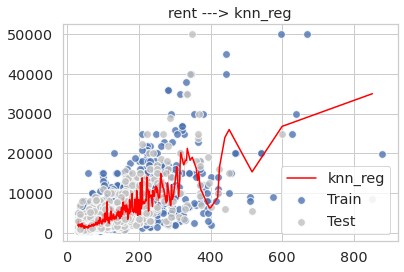

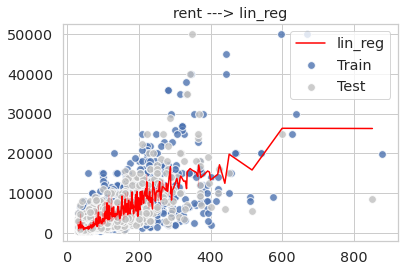

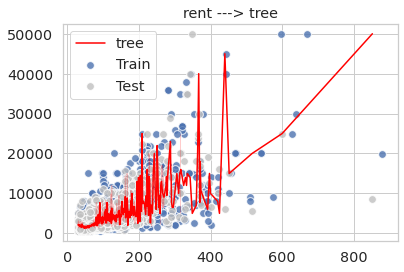

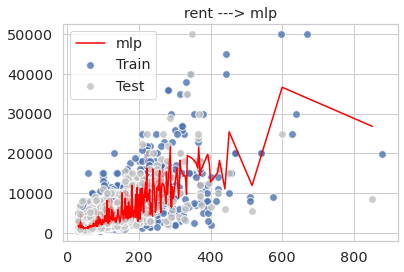

In [ ]:
for tipo, nome, rmse, r2, mae, cv_rmse, cv_r2, cv_mae, previsoes in resultados:
  if tipo == 'rent':
    fig = plt.subplots(1)
    sns.scatterplot(x=X_train_rent[0:5000,0], y=y_train_rent[0:5000].ravel(), s=60, linewidth=1, alpha=0.8, label='Train')
    sns.scatterplot(x=X_test_rent[0:5000, 0], y=y_test_rent[0:5000].ravel(), s=60, linewidth=1, alpha=0.8, color='silver', label='Test')
    sns.lineplot(x=X_test_rent[:, 0], y=previsoes[:].ravel(), color='red', label=nome)  
    plt.title(tipo + ' ---> ' + nome)
    plt.plot()

Dividiu-se os resultados dos modelos de locação em 2 sub dataframes para melhor compara-los e normalizou-se também 0 à 1 os valores obtidos tanto do RMSE quanto do MAE.

                RMSE        R2          MAE
Modelo                                     
mlp      1773.109784  0.667595   820.561289
lin_reg  1992.597432  0.556343  1023.514658
tree     2650.792835  0.420294   999.825027
knn_reg  2250.920552  0.378876  1043.249953
             CV_RMSE     CV_R2       CV_MAE
Modelo                                     
mlp      1595.634810  0.802792   798.426680
lin_reg  1703.665802  0.721702   989.588477
tree     2234.275666  0.697777   979.605896
knn_reg  2114.661588  0.647282  1096.948148


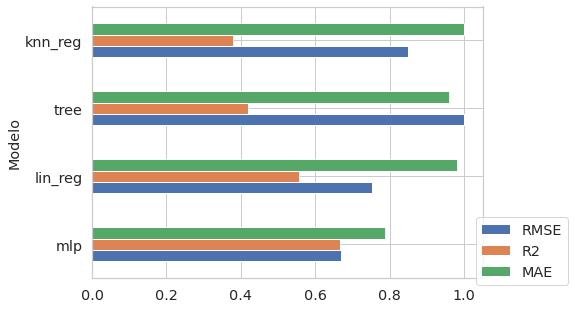

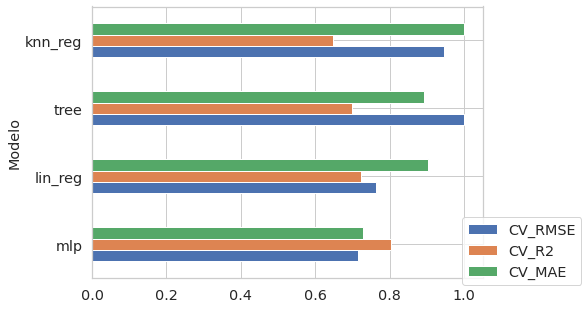

In [ ]:
df_resultados_sale = df_resultados.query('Negotiaion_Type == "rent"')

df_sem_cross = df_resultados_sale[['RMSE', 'R2', 'MAE']].sort_values(by=['R2'], ascending=False)
print(df_sem_cross)

df_cross = df_resultados_sale[['CV_RMSE', 'CV_R2', 'CV_MAE']].sort_values(by=['CV_R2'], ascending=False)
print(df_cross)

df_sem_cross[['RMSE']] = df_sem_cross[['RMSE']]/(df_sem_cross[['RMSE']].max())
df_sem_cross[['MAE']] = df_sem_cross[['MAE']]/(df_sem_cross[['MAE']].max())

df_cross[['CV_RMSE']] = df_cross[['CV_RMSE']]/(df_cross[['CV_RMSE']].max())
df_cross[['CV_MAE']] = df_cross[['CV_MAE']]/(df_cross[['CV_MAE']].max())

df_sem_cross.plot(kind='barh', legend=True, figsize=(7,5))
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.1))
df_cross.plot(kind='barh', legend=True, figsize=(7,5))
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.1))

##6.3 Discussão dos Resultados

Analisando os 4 modelos obtidos anteriormente para cada tipo de negociação, pode-se notar que os modelos que melhor aprensentaram resultados para venda de imóveis, foram os modelos de Árvore de Decisão e o Multilayer Perceptron, mesmo ápos a validação cruzada, tendos os melhores resultados de R2 e os menores valores para RMSE e MAE.

Por sua vez, ao analisar os desempenhos para venda de imóveis, vemos que ocorre uma mudança no *ranking* de modelos, no qual, o MLP apresenta os melhores valores em relação aos demais, seguido do modelo de Regressão Linear.

# 7. Conclusão

Com o trabalho proprosto, consegui-se analisar um dataset contendo informações de venda e locação de imóveis da cidade de São Paulo com diferentes características, com o intúito de conseguir prever qual o valor estará sendo negociado cada tipo de imóvel para cada tipo de contrato.

Treinou-se quatro diferentes modelos de aprendizado de máquina, tendo como melhor resultado o algorítimo de *Multilayer Perceptron* com validação cruzada, para ambos os casos.

Acredita-se que com uma maior quantidade de dados, consegue-se obter um melhor resultado, além da realização de uma melhor seleção das variáveis disponíveis e possivelmente a separação do dataset em varios subconjutos afim de criar um modelo para cada distrito. Contudo, os resultados apresentados são satisfatórios, os quais podem ajudar na previsão da negociação de imóveis.

